# COCO dataset
1. Download the COCO VQA v2 Dataset<br>

    Official Source:<br>
        Visit the official VQA website: https://visualqa.org/<br>
        Download the following files:<br>

            v2_OpenEnded_mscoco_val2014_annotations.json<br>
            v2_OpenEnded_mscoco_val2014_questions.json<br>
or use this links:<br>
https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip<br>
https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip<br>
2. Download COCO Images<br>
    Obtain COCO Images:<br>
        Download the COCO images from the official COCO website: https://cocodataset.org/<br>
            You'll need to download the images for the val2014.<br>

3. Organize Files (Optional)<br>

    Create a directory structure to organize your downloaded files. For example:<br>

    coco_vqa_v2/<br>
        val2014/ <br>
            annotations/ <br>
                v2_OpenEnded_mscoco_val2014_annotations.json <br>
            questions/<br>
                v2_OpenEnded_mscoco_val2014_questions.json <br>
            images/ <br>
                COCO_val2014_000000000001.jpg <br>
                COCO_val2014_000000000002.jpg <br>
                ...<br>

In [46]:
import json
from sklearn.model_selection import train_test_split

def filter_yes_no_questions(annotations):
  """
  Filters VQA COCO dataset for yes/no questions.

  Args:
    annotations: List of annotations.

  Returns:
    A list of dictionaries, where each dictionary represents an annotation 
    for a yes/no question.
  """

  yes_no_annotations = []
  for annotation in annotations:
    if annotation['answer_type'] == 'yes/no':
      yes_no_annotations.append(annotation)

  return yes_no_annotations

def split_data(annotations, test_size=0.1, val_size=0.1):
  """
  Splits the filtered annotations into train, validation, and test sets.

  Args:
    annotations: List of annotations for yes/no questions.
    test_size: Proportion of data for the test set.
    val_size: Proportion of data for the validation set.

  Returns:
    train_annotations, val_annotations, test_annotations: 
      Lists of annotations for train, validation, and test sets, respectively.
  """

  train_val_annotations, test_annotations = train_test_split(annotations, test_size=test_size, random_state=42)
  train_annotations, val_annotations = train_test_split(train_val_annotations, test_size=val_size, random_state=42)

  return train_annotations, val_annotations, test_annotations

def create_image_question_answer_strings(annotations, question_dict):
  """
  Creates a list of strings in the format: "COCO_val2014_000000524450.jpg#1\tCould this be tour bus ?\tyes"

  Args:
    annotations: List of annotations.
    question_dict: Dictionary mapping question_ids to questions.

  Returns:
    A list of strings in the specified format.
  """

  data_strings = []
  for annotation in annotations:
    image_id = annotation['image_id']
    image_filename = f"COCO_val2014_{str(image_id).zfill(12)}.jpg"
    question_id = annotation['question_id']
    question = question_dict[question_id].replace('?', ' ?') 
    answers = annotation['answers'][0] 
    answer = answers['answer'] 
    data_string = f"{image_filename}\t{question}\t{answer}"
    data_strings.append(data_string)

  return data_strings

def save_data_to_file(data_strings, filename):
  """
  Saves a list of strings to a text file.

  Args:
    data_strings: List of strings to be saved.
    filename: Name of the output file.
  """

  with open(filename, 'w') as f:
    for data_string in data_strings:
      f.write(data_string + '\n')



In [47]:
# Load annotations and questions
with open('/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/Annotations/v2_mscoco_val2014_annotations.json', 'r') as f:
    val_annotations = json.load(f)['annotations']

with open('/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/Questions/v2_OpenEnded_mscoco_val2014_questions.json', 'r') as f:
    questions = json.load(f)['questions']

# Create a dictionary to map question_id to question
question_dict = {q['question_id']: q['question'] for q in questions}



In [48]:
# Filter for yes/no questions
val_yes_no_annotations = filter_yes_no_questions(val_annotations)

# Split data (using the entire val2014 set as validation)
train_annotations, val_annotations, test_annotations = split_data(val_yes_no_annotations, test_size=0.75, val_size=0.5) 

# Create data strings for each split
train_data_strings = create_image_question_answer_strings(train_annotations, question_dict)
val_data_strings = create_image_question_answer_strings(val_annotations, question_dict)
test_data_strings = create_image_question_answer_strings(test_annotations, question_dict)



print(f"Number of train examples: {len(train_data_strings)}")
print(f"Number of validation examples: {len(val_data_strings)}")
print(f"Number of test examples: {len(test_data_strings)}")

Number of train examples: 10067
Number of validation examples: 10068
Number of test examples: 60406


In [49]:
# Save data to files
save_data_to_file(train_data_strings, '/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/vaq2.0.TrainImages.txt')
save_data_to_file(val_data_strings, '/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/vaq2.0.ValImages.txt')
save_data_to_file(test_data_strings, '/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/vaq2.0.TestImages.txt') 

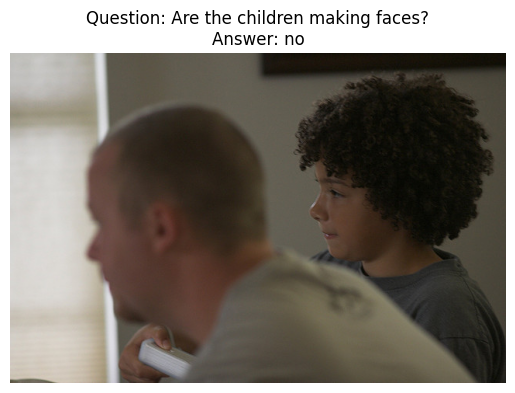

In [50]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import os


def visualize_example(annotation, question, image_path):
  """
  Visualizes a VQA example with the image and question.

  Args:
    annotation: A dictionary containing the annotation information.
    question: The question string.
    image_path: Path to the image file.
  """

  if 'multiple_choice_answers' in annotation:
      answer = annotation['multiple_choice_answers'][0]  
  elif 'answers' in annotation: 
      answers = annotation['answers'][0] 
      answer = answers['answer']
  elif 'choices' in annotation: 
      answer = annotation['choices'][0] 
  else: 
      print(f"Warning: No answer key found in annotation: {annotation}") 
      answer = "Unknown" 

  try:
      img = Image.open(image_path).convert('RGB')
      plt.imshow(img)
      plt.title(f"Question: {question}\nAnswer: {answer}")
      plt.axis('off')
      plt.show()
  except FileNotFoundError as e:
      print(f"Error loading image: {e}")
      print(f"Image path: {image_path}") 


# Select a random yes/no question
import random
random_index = random.randint(0, len(val_yes_no_annotations) - 1)
selected_annotation = val_yes_no_annotations[random_index]

# Get image path (assuming image IDs are consistent)
image_id = selected_annotation['image_id']
image_path = f"/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/Images/COCO_val2014_{str(image_id).zfill(12)}.jpg"  # Replace with the actual image path

# Get the question from the question dictionary
question_id = selected_annotation['question_id']
question = question_dict[question_id]

# Visualize the example
visualize_example(selected_annotation, question, image_path)

In [40]:
#resize

In [41]:
def save_and_resize_images(annotations, image_dir, output_dir, new_size=(224, 224)):
    """
    Saves and resizes images from annotations.

    Args:
    annotations: List of annotations.
    image_dir: Directory containing the original images.
    output_dir: Directory to save the resized images.
    new_size: Tuple specifying the new size for resizing.
    """

    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for annotation in annotations:
        image_id = annotation['image_id']
        image_filename = f"COCO_val2014_{str(image_id).zfill(12)}.jpg"
        image_path = os.path.join(image_dir, image_filename)

        try:
            img = Image.open(image_path).convert('RGB')
            img = img.resize(new_size)
            output_path = os.path.join(output_dir, image_filename)
            img.save(output_path)
        except FileNotFoundError as e:
            print(f"Error loading image: {e}")
            print(f"Image path: {image_path}")

In [45]:
# Set image directories
import os
from PIL import Image
image_dir = "/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/Images/"  # Replace with the actual path to your original images
output_dir = "/home/mouatasim/0vqa_v2/coco_vqa_v2/valid2014/Images-resize/"  # Replace with the desired output directory

# Save and resize images
save_and_resize_images(val_yes_no_annotations, image_dir, output_dir)